In [2]:
import os
import sys
import io
import re
import pickle
import gzip
import zipfile
import string
import json
from itertools import combinations
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

import dash
import dash_html_components as html
import dash_cytoscape as cyto

In [3]:
with gzip.open('../data/pickles/df_yummly.pkl.gzip', 'rb') as f:
    df_yummly = pickle.load(f)

In [4]:
df_yummly.drop(['id',
                #'flavors', 
                'ingredients',
                'PrepTime'], axis=1, inplace=True)
df_yummly.head()

,flavors,recipeName,cuisine,simpler_ingredients
0,None,Healthier Red Thai Chicken Curry - without the...,thai,"[olive oil, chicken breast, chillies, ginger, ..."
1,"{'piquant': 0.16666666666666666, 'meaty': 0.16...",20 Minute Thai Basil Beef and Lemongrass Rice ...,thai,"[jasmine rice, coconut milk, water, toasted se..."
2,None,"Thai Pumpkin Laksa with Crunchy ""Fried"" Chickp...",thai,"[sesame oil, garlic, fresh ginger, seed, scall..."
3,"{'piquant': 0.5, 'meaty': 0.6666666666666666, ...",Thai Basil Chicken,thai,"[vegetable oil, sriracha sauce, crushed red pe..."
4,None,Skinny Thai Chicken Meatballs with Peanut Sauce,thai,"[ground chicken, scallion, chopped cilantro, f..."


In [5]:
df_yummly.flavors.dropna().reset_index(drop=True).loc[5]

{'piquant': 0.16666666666666666,
 'meaty': 0.6666666666666666,
 'bitter': 0.16666666666666666,
 'sweet': 0.16666666666666666,
 'sour': 0.8333333333333334,
 'salty': 0.16666666666666666}

In [6]:
df_yummly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16781 entries, 0 to 16780
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   flavors              11680 non-null  object
 1   recipeName           16781 non-null  object
 2   cuisine              16781 non-null  object
 3   simpler_ingredients  16781 non-null  object
dtypes: object(4)
memory usage: 655.5+ KB


### Decreasing names' sizes

In [7]:
#stopwords = ['the', 'in', 'one', 'of', 'and', 'with', 'without', 'shopbought', 'healthier', 'skinny']
def clean(text):
    text = re.sub(r'([^a-zA-Z ]+)', '', text)
    #for word in stopwords:
    text = re.sub(r'\b(the|in|one|of|and|with|without|shopbought|healthier|skinny)\b','' , text, flags=re.IGNORECASE)
    text = re.sub(r'[\s\t\n]+', ' ', text, flags=re.IGNORECASE)
    return text

In [8]:
df_yummly['short_recipeName'] = df_yummly.recipeName
df_yummly['short_recipeName'] = df_yummly.short_recipeName.apply(clean)

In [9]:
#series = df_yummly.short_recipeName + ' '
#freqdist = Counter(series.sum().split())
#freqdist.most_common(250)

In [10]:
df_yummly.short_recipeName

0                             Red Thai Chicken Curry sauce
1             Minute Thai Basil Beef Lemongrass Rice Bowls
2               Thai Pumpkin Laksa Crunchy Fried Chickpeas
3                                       Thai Basil Chicken
4                      Thai Chicken Meatballs Peanut Sauce
                               ...                        
16776    Spanish Basque Salt Cod Casserole Bacalao a La...
16777                                Spanish Style Chicken
16778                                    Spanish Spareribs
16779                                    Vegetarian Paella
16780                    Pollo Con Chorizo Chicken Chorizo
Name: short_recipeName, Length: 16781, dtype: object

### Subsampling

In [11]:
df_yummly.cuisine.value_counts()

english       1000
spanish       1000
american      1000
japanese      1000
french         999
italian        999
indian         998
greek          998
german         997
chinese        997
moroccan       996
mexican        996
thai           996
irish          849
hawaiian       776
cuban          729
hungarian      613
swedish        543
portuguese     295
Name: cuisine, dtype: int64

In [12]:
samples = []
for cuisine in df_yummly.cuisine.unique():
    samples.append(df_yummly[df_yummly.cuisine == cuisine].dropna().sample(8))
df_sample = pd.concat(samples)
df_sample.reset_index(inplace=True, drop=True)
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   flavors              152 non-null    object
 1   recipeName           152 non-null    object
 2   cuisine              152 non-null    object
 3   simpler_ingredients  152 non-null    object
 4   short_recipeName     152 non-null    object
dtypes: object(5)
memory usage: 6.1+ KB


### Creating the Graph

In [20]:
G = nx.Graph()
for idx in df_sample.index:
    #assert isinstance(df_yummly.loc[idx, 'simpler_ingredients'], list)
    for ing in df_sample.loc[idx, 'simpler_ingredients']:
        if ing not in G:
            G.add_node(ing,
                       color='#ffddff', 
                       nodetype='ingredient',
                       weight=1
                      )
        else:
            G.nodes[ing]['weight'] = G.nodes[ing]['weight'] + 1
        
    for n1, n2 in combinations(df_sample.loc[idx, 'simpler_ingredients'], 2):
        if not G.has_edge(n1,n2):
            G.add_edge(n1,n2, 
                       weight=1, 
                       color='#0000FF')
        else:
            G.edges[n1,n2]['weight'] += 1

In [21]:
for idx in df_sample.index:
    if df_sample.loc[idx, 'cuisine'] not in G:
        G.add_node(df_sample.loc[idx, 'cuisine'],
                   color='#ddffff',
                   weight=1,
                   nodetype='cuisine')
    else:
        G.nodes[df_sample.loc[idx, 'cuisine']]['weight'] = G.nodes[df_sample.loc[idx, 'cuisine']]['weight'] + 1
        
    for ing in df_sample.loc[idx, 'simpler_ingredients']:
        if not G.has_edge(ing, df_sample.loc[idx, 'cuisine']):
            G.add_edge(ing, df_sample.loc[idx, 'cuisine'], 
                       weight=1, 
                       color='#ffeedd')
        else:
            G.edges[ing, df_sample.loc[idx, 'cuisine']]['weight'] += 1

In [22]:
for idx in df_sample.index:
    G.add_node(df_sample.loc[idx, 'short_recipeName'], 
               nodetype = 'recipe', 
               color = '#F5A9F2',
               weight = 0)
    
    for ing in df_sample.loc[idx, 'simpler_ingredients']:
        if not G.has_edge(ing, df_sample.loc[idx, 'short_recipeName']):
            G.add_edge(ing, df_sample.loc[idx, 'short_recipeName'], 
                       weight=1, 
                       color='#eeffdd')
        #else:
        #    G.edges[ing, df_sample.loc[idx, 'cuisine']]['weight'] += 1

In [23]:
for node in G.nodes(data=True):
    print(node)
    break
for edge in G.edges(data=True):
    print(edge)
    break

('canola oil', {'color': '#ffddff', 'nodetype': 'ingredient', 'weight': 6})
('canola oil', 'ground turkey breast', {'weight': 1, 'color': '#0000FF'})


In [33]:
nx.get_edge_attributes(SG,'frequency').values()

dict_values([])

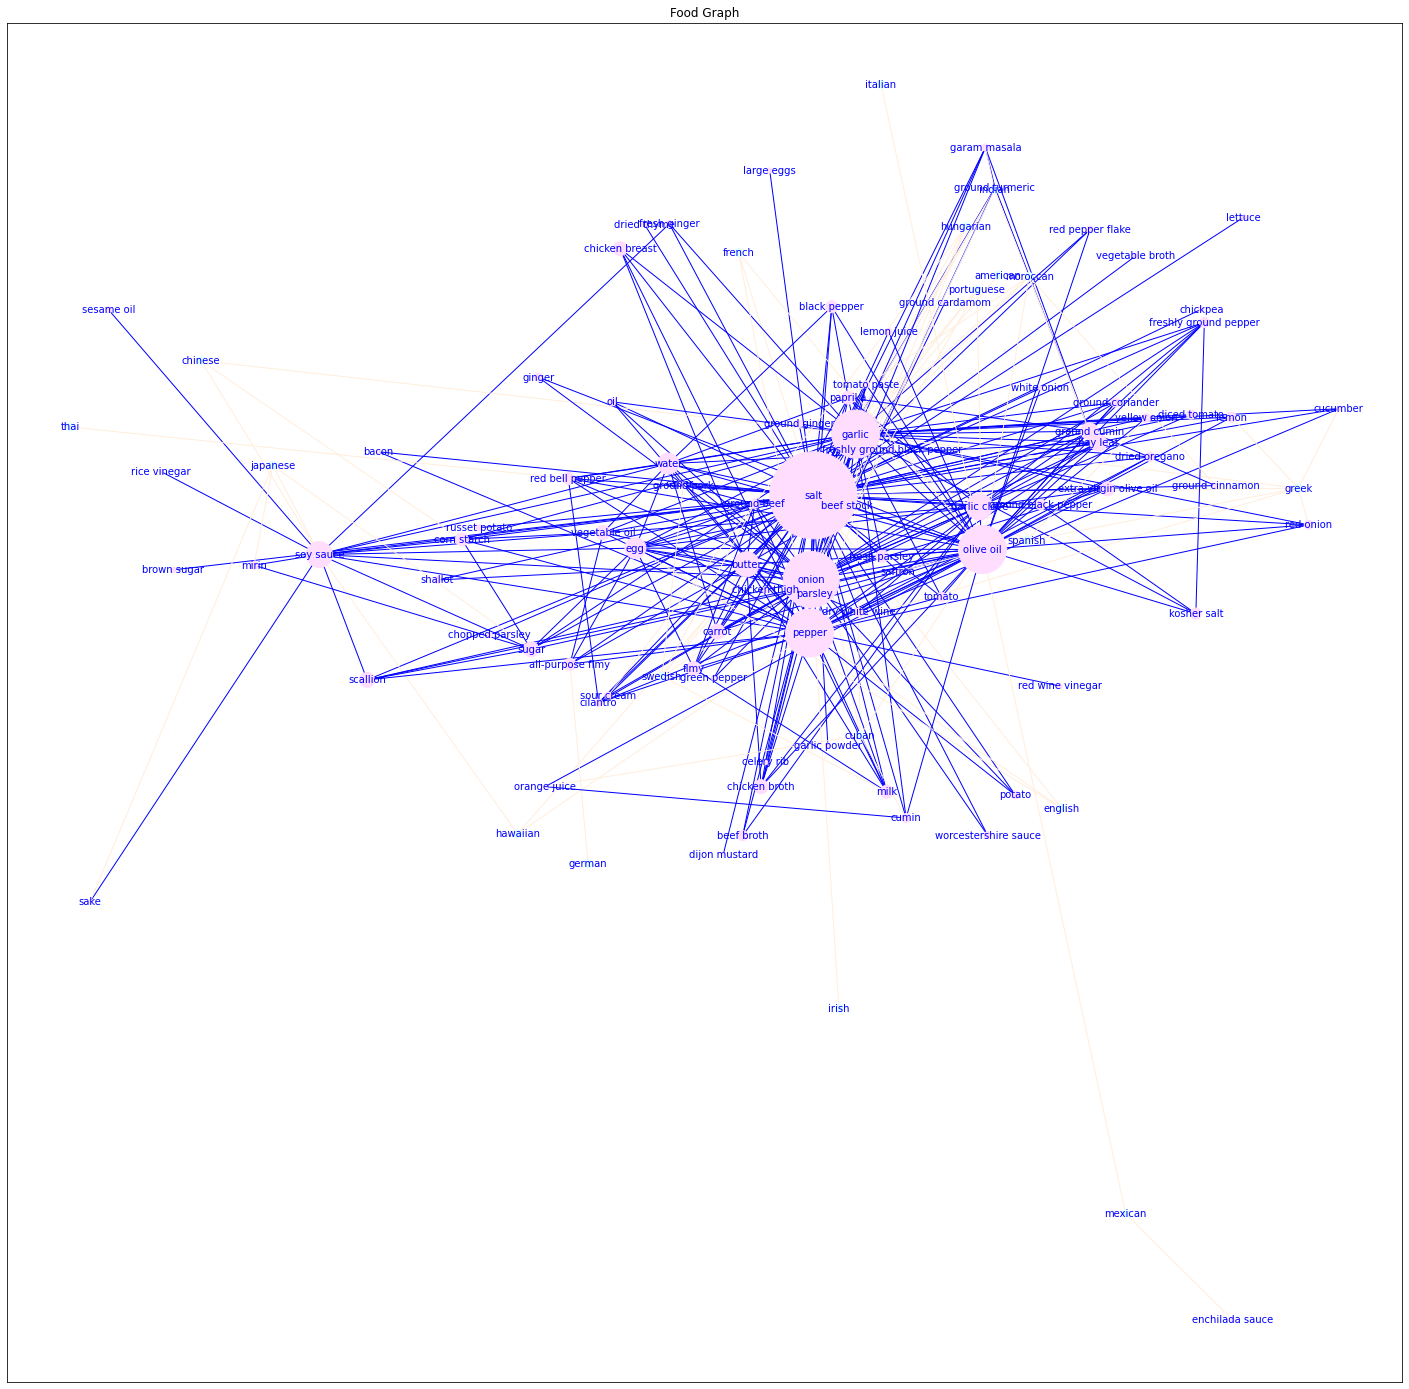

In [42]:
#SG = G.subgraph([n for n, attrdict in G.nodes(data=True) if attrdict['language'] == 'english'])
SG = nx.Graph((u,v,d) for u,v,d in G.edges(data=True) if d['weight'] > 3)

fig, ax = plt.subplots(figsize=(25,25))
ax.set_title("Food Graph")
#pos = graphviz_layout(G, prog='neato', args='') # https://networkx.github.io/documentation/stable/reference/drawing.html
pos = nx.spring_layout(G, scale=1)
#pos = nx.kamada_kawai_layout(G, scale=1)
#pos = nx.spectral_layout(G, scale=1)

nx.draw_networkx(SG, 
                 pos=pos, 
                 #arrows=True,
                 with_labels=True,
                 ax=ax,
                 nodelist=SG.nodes(),
                 edgelist=SG.edges(),
                 node_size=[nx.get_node_attributes(G,'weight')[g]**2 for g in SG.nodes()],
                 node_color=[nx.get_node_attributes(G,'color')[g] for g in SG.nodes()],
                 node_shape='o',
                 alpha=1.0,
                 cmap=None,
                 vmin=None,
                 vmax=None,
                 linewidths=1.0,
                 width=list(nx.get_edge_attributes(SG,'frequency').values()),
                 edge_color=[nx.get_edge_attributes(SG,'color')[g] for g in SG.edges()],
                 edge_cmap=None,
                 edge_vmin=None,
                 edge_vmax=None,
                 style='dashdot',
                 labels=None ,
                 font_size=10,
                 font_color='blue',
                 font_weight='normal',
                 font_family='sans-serif',
                 label='Food Graph',)

In [47]:
#dic = nx.cytoscape_data(SG)
#dic['elements']

In [43]:
#for n in G.nodes(data=True):
for n in G.edges(data=True):    
    print(n)
    break

('canola oil', 'ground turkey breast', {'weight': 1, 'color': '#0000FF'})


In [50]:
for n, d in G.nodes(data=True):
    print(n, d)
    break

canola oil {'color': '#ffddff', 'nodetype': 'ingredient', 'weight': 6}


In [48]:
nodes = [{'data': {'id': node, 
                   'value': node,
                   'name': node,
                   'label': node,
                   'color': d['color'],
                   #'nodetype': d['nodetype'],
                   'weight': d['weight'],
                  },
          #'position': {'x': 2000*pos[node][0], 'y': 2000*pos[node][1]},
          #'locked': 'true'
          'classes': d['nodetype']
         } 
          for node, d in G.nodes(data=True)]

edges = [{'data': {'source': e1, 
                   'target': e2,
                   'color': d['color'],
                   'weight': d['weight'],
                  },
         }
          for e1, e2, d in G.edges(data=True)]

elements = nodes + edges

In [20]:
#https://networkx.org/documentation/stable/reference/readwrite/json_graph.html
with open('../data/food.json', 'w') as f:
    #f.write(json.dumps(nx.cytoscape_data(SG)))
    f.write(json.dumps(elements))

In [21]:
with open('../data/food.json', 'r') as f:
    data = json.loads(f.read())
    
#data['elements']